In [3]:
"""
Data exploration
"""
#Magic function: %matplotlib inline
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Set aesthetic parameters in one step
sns.set()

csv = '../datasets/Reviews.csv'
data = pd.read_csv(csv)

print("Columns: ", data.columns)
print("Rows: ", data.shape[0], " Cols: ", data.shape[1])

Columns:  Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
Rows:  568454  Cols:  10


Score          1         2        3         4         5
scores  0.091948  0.052368  0.07501  0.141885  0.638789
70& of total reviews is comprised of score 4 and 5


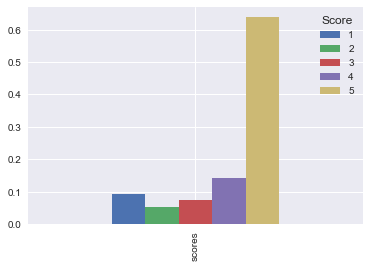

In [4]:
score_pct = np.bincount(data['Score']) / data.shape[0]

scores = pd.DataFrame(np.random.rand(1,5),
                     index=['scores'],
                     columns=pd.Index([1,2,3,4,5],
                                     name='Score'))

scores.iloc[0] = score_pct[1:]
scores.plot.bar()

print(scores)
print('70& of total reviews is comprised of score 4 and 5')



sentiment  negative  positive
count      0.218401  0.781599
78% of reviews is positive


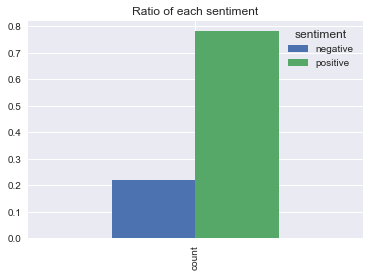

In [5]:
"""
Training classier and prediction
Categorized every review as either positive or negative, 
and will train a classifier to predict these two values.
"""

#We suffle the rows and extract an % of the rows
df_reduced = data.sample(frac=0.04, random_state=7)
reduced_data_size = df_reduced.shape[0]

#scores >= 4 positive, < negative 
reduced_labels = np.array([df_reduced['Score'] >= 4])[0][:].astype(int)
reduced_texts = df_reduced['Text'].values

#Percentage value of each sentiment 
reduced_sentiment_pct = np.bincount(reduced_labels) / reduced_data_size

sentiment = pd.DataFrame(np.random.rand(1,2),
                        index=['count'],
                        columns=pd.Index(["negative", "positive"],
                                        name='sentiment'))
sentiment.iloc[0] = reduced_sentiment_pct
sentiment.plot.bar(title="Ratio of each sentiment")

print(sentiment)
print('78% of reviews is positive')


In [6]:
#using 80% of data as training set and 20 as set test
train_size = int(reduced_data_size*0.8)

text_train = reduced_texts[:train_size]

y_train = reduced_labels[:train_size]

text_test = reduced_texts[train_size:]

y_test = reduced_labels[train_size:]

print('text_train: ', text_train.shape[0])
print('text_test: ', text_test.shape[0])

text_train:  18190
text_test:  4548


In [7]:
"""
tranform the texts into an appropiate format (numerical values)
so that a classifier can be trained on them, using two methods:
    *Bag-of-words (tokenization text-> numerical)
    *TFIDF
"""
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://cdn-images-1.medium.com/max/800/1*YB7gbpsylW5rJu7ZkL5Iww.png")



In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(text_train)

X_train = vect.transform(text_train)
print("Xtrain: ", X_train.shape, "sparse matrix")

X_test = vect.transform(text_test)
print("Xtest: ", X_test.shape, "sparse matrix")

# a sparse matrix is a matrix that contains only non-zero entries

/Users/jacoboleon/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Xtrain:  (18190, 27093) sparse matrix
Xtest:  (4548, 27093) sparse matrix


In [9]:
"""
Fit a logistic regression

Note:

I use class_weigtht=”balanced” in instantiation below.
This has the effect of penalizing the mistakes on minority 
class, negative class in this dataset.

I use GridSearchCV with “roc_auc”, not “classification 
accuracy”. Justification of this is written in the below 
section.

"""

'\nFit a logistic regression\n\nNote:\n\nI use class_weigtht=”balanced” in instantiation below.\nThis has the effect of penalizing the mistakes on minority \nclass, negative class in this dataset.\n\nI use GridSearchCV with “roc_auc”, not “classification \naccuracy”. Justification of this is written in the below \nsection.\n\n'

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(class_weight="balanced",
                           random_state=0)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(logreg, param_grid, scoring="roc_auc",
                   cv=5)

logreg_train = grid.fit(X_train, y_train)

pred_logreg = logreg_train.predict(X_test)

confusion = confusion_matrix(y_test, pred_logreg)

print(confusion)

print("Classification accuracy is: ", (confusion[0][0] + confusion[1][1]) / np.sum(confusion))

/Users/jacoboleon/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


[[ 811  199]
 [ 432 3106]]
Classification accuracy is:  0.86125769569


In [11]:
"""
In general, we want to increase the number of True Negatives and that of True Positives. 
while minimizing the number of False Negatives and False Positives

Classification accuracy is calculated as : (TN+TP) / (TN+TP+FP + FN).

"""
print("True Negatives: ", confusion[0][0])
print("True Positives: ", confusion[0][1])
print("False Negatives: ", confusion[1][0])
print("False Positives: ", confusion[1][1])


from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://cdn-images-1.medium.com/max/800/1*GpAqhezaMuldOt5i4PvdkQ.png")


True Negatives:  811
True Positives:  199
False Negatives:  432
False Positives:  3106


In [16]:
"""
ROC & AUC

ROC: a curve plotted against False Positive Rate (FPR) and
True Positive Rate (TPR) and it considers all thresholds of a classifier.
(TPR is also called Recall.)
The best point is a top-left corner where the lowest FPR 
and the highest TPR can be achieved.
(Best point: min FPR & max TPR)

AUC: Area Under the ROC Curve. Possibles values it can take
called Range of AUC is [0,1] (worst, best).
Random prediction always results in 0.5 AUC score.
AUC is the probability that a randomly selected sample from
positive class gives higher score than a sample from negative class,
or degree of condifence in positive class.
Thus  AUC gives traditional information about the prediction, 
namely information about both a comparision of models 
(e.g. some model might be a random classifier) and a appropiate threshold
wich may produce a higher classification rate. That is why
I used AUC as a metric in GridSearch
"""

'\nROC & AUC\n\nROC: a curve plotted against False Positive Rate (FPR) and\nTrue Positive Rate (TPR) and it considers all thresholds of a classifier.\n(TPR is also called Recall.)\nThe best point is a top-left corner where the lowest FPR \nand the highest TPR can be achieved.\n(Best point: min FPR & max TPR)\n\nAUC: Area Under the ROC Curve. Possibles values it can take\ncalled Range of AUC is [0,1] (worst, best).\nRandom prediction always results in 0.5 AUC score.\nAUC is the probability that a randomly selected sample from\npositive class gives higher score than a sample from negative class,\nor degree of condifence in positive class.\nThus  AUC gives traditional information about the prediction, \nnamely information about both a comparision of models \n(e.g. some model might be a random classifier) and a appropiate threshold\nwich may produce a higher classification rate. That is why\nI used AUC as a metric in GridSearch\n'

AUC score is:  0.905772965652


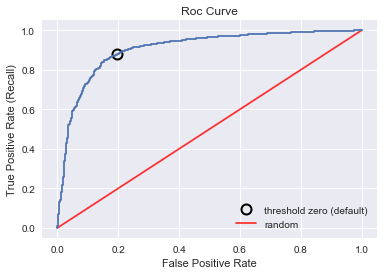

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(y_test, 
                                 grid.decision_function(X_test))
#find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))

plt.plot(fpr[close_zero], tpr[close_zero], 'o', 
         markersize=10, label="threshold zero (default)",
        fillstyle="none", c='k', mew=2)

plt.plot([0,1], linestyle='-', color='r', label='random',
        alpha=0.8)

plt.legend(loc=4)

plt.plot(fpr, tpr, label="ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate (Recall)")

plt.title("Roc Curve")

print("AUC score is: ", auc(fpr, tpr))


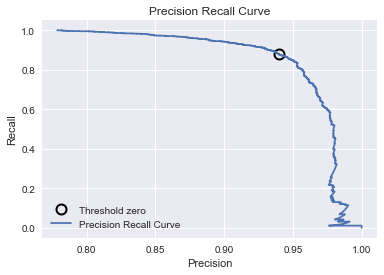

In [21]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = \
precision_recall_curve(y_test, 
                       logreg_train.decision_function(X_test))

close_zero = np.argmin(np.abs(thresholds))

plt.plot(precision[close_zero], recall[close_zero], 'o',
        markersize=10, label="Threshold zero", fillstyle="none",
        c="k", mew=2)

plt.plot(precision, recall, label="Precision Recall Curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision Recall Curve")
plt.legend(loc="best")


In [ ]:
https://towardsdatascience.com/how-a-simple-algorithm-classifies-texts-with-moderate-accuracy-79f0cd9eb47